# "Accelerated ODE Inference with PyDEns and PyMC3"
> "An introduction to training neural networks to solve parametric families of ODEs with PyDEns and using PyMC3 to quickly sample the posterior."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Jonathan Lindbloom
- hide: true

# !!! This is a work-in-progress !!!

## Traditional Approaches

As a newcommer to the PyMC3 community about a year ago, one of the things I was most excited to learn about was using PyMC3 to perform Bayesian inference for systems of ordinary differential equations (ODEs). In order to take advantage of the efficiency of the NUTS sampler you must be able to provide gradients of the model with respect to each of the model parameters, which can be tricky for ODEs. In my experiences, ignoring the case in which you happen to know the analytic solution there seems to be three approaches to achieving this:

1. Write an ODE solver entirely in Theano which automatically gives you ability to get gradients via autodiff. This might seem like the easiest way to get the gradients, but you lose the confidence provided by well-tested solvers and it is hard to control the errors in the calculated gradients. 
2. Use an ODE solver coupled with the [adjoint method](https://en.wikipedia.org/wiki/Adjoint_state_method) to get the gradients by solving an associated system of ODEs. This is what is done in the package [sunode](https://github.com/aseyboldt/sunode).
3. Use an ODE solver coupled with local sensitivity analysis to get the gradients by solving an augmented system of ODEs. This is the approach taken in the PyMC3 example on the [Lotka-Volterra model with manual gradients](https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_with_manual_gradients.html).

However, you may have noticed that sometimes these methods can be slow. Let's take a look at what might cause this. Suppose we are given some parametric ODE system $$ \frac{d\mathbf{x}}{dt} = f(\mathbf{x}, t; \theta) $$ with an initial condition $\mathbf{x}_0$ and would like to know both $\mathbf{x}(T)$ and $\frac{\partial \mathbf{x}(T)}{\partial \theta}$  for some later time $T > 0$. Traditional methods for approximating $\mathbf{x}(T)$ boil down to computing a sequence of points $\{ (t_j, \mathbf{x}^{j}) \}_{j=0}^{M}$ with the goal being that $\mathbf{x}^M \approx \mathbf{x}(T)$. We might compute this sequence using the [Euler method](https://en.wikipedia.org/wiki/Euler_method#:~:text=The%20Euler%20method%20is%20a,proportional%20to%20the%20step%20size.) or better yet a [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). If we want to increase the accuracy of our approximation $\mathbf{x}^M \approx \mathbf{x}(T)$ we can decrease the timestep of our method which consequently lengthens the sequence of intermediary points we must compute. If all we care about is getting $\mathbf{x}^M$ correct and won't use the other points $\{ \mathbf{x}^{j}\}_{j=0}^{M-1}$ for anything, we end up computing an awfully large amount of intermediary points we don't actually care about. Now you might point out that in practice we often get a whole time-series of observations and that actually we *will* be using many of these intermediary points. OK, fine. But what if our desired numerical accuracy of our solver requires a timestep that makes our observations sparse in time when compared to the granularity of our approximating sequence? This is effectively the same dilemma as before --- we approximate the solution of the ODE at a ton of times that we don't actually care about it. Inference with ODEs using these methods can be slow since each step of MCMC must re-calculate these lengthy sequences of points for a different set of parameters $\theta$. If we want to speed up ODE inference, it seems like our time would be well-spent trying to avoid the calculation of these sequences at each step. The goal of this post is to introduce a new and exciting alternative to achieve this!

# Thinking Differently About Differential Equations

A concept we need to introduce before we dive in is the *flow map* associated to an autonomous ODE. Suppose that we know we start at $\mathbf{x}_0 \in \mathbb{R}^d$ and want to know where in the phase space we'll be at time $t = \tau$. The *flow map* $\Phi_\tau : \mathbb{R}^d \to \mathbb{R}^d$ is the function that takes us from $\mathbb{x}_0$ directly to $\mathbb{x}(\tau)$, as well as from any other possible initial condition $\mathbb{x}_0'$ we could've chosen to where it would be at time $t = \tau$. In other words, 
$$ \Phi_\tau(\mathbb{x}_0) = \mathbb{x}(\tau) $$ where $\mathbb{x}(t)$ is the solution to the initial value problem
\begin{equation}
    \begin{cases}
      \cfrac{d \mathbb{x}}{dt} &= f(\mathbb{x}; \theta) & \text{for $t \in [0, \tau]$}\\
      \mathbb{x}(0) &= \mathbb{x}_0
    \end{cases}       
\end{equation}

If we knew the flow map $\Phi_\tau$ for any $\mathbb{x}_0 \in \mathbb{R}^d$ and $\tau > 0$ then we wouldn't have to bother with calculating an approximating sequence with a traditional solver in order to approximate $\mathbb{x}(T)$ --- we could just evaluate $\Phi_T(\mathbb{x}_0) = \mathbb{x}(T)$. If we also knew $\frac{\partial \Phi_\tau}{\partial \theta}$, the gradient of the flow map with respect to the ODE parameters, we would have all of the requisite information we need to then proceed with using a gradient-based sampler like NUTS. This is all much easier said than done, but we will proceed with trying to approximate $\Phi_\tau$ and $\frac{\partial \Phi_\tau}{\partial \theta}$.


# Using Neural Networks to Solve ODEs

If you're reading this post and don't know much about neural networks, don't worry --- I'm no expert either. In this post, a "neural network" simply refers to some function $F_{\mathcal{\eta}} : \mathbb{R}^{d_1} \to \mathbb{R}^{d_2}$ where $\eta$ represents some set of trainable parameters (treat these completely separate from our model parameters $\theta$). By "trainable" I mean that we can tweak $\eta$ in order to get $F_\eta$ to "agree" with some other function $G: \mathbb{R}^d \to \mathbb{R}^d$, and by "agree" I mean that given some set of points $ P \subset \mathbb{R}^{d_1} $ we can tweak $\eta$ to get $F_\eta(\mathbb{x}) \approx G(\mathbb{x})$ for $\mathbb{x} \in P$. Recall that the flow map $\Phi_\tau$ we introduced was a function $\Phi_\tau: \mathbb{R}^d \to \mathbb{R}^d$. Let's define a new function $\Phi$ by moving $\tau$ out of the subscript such that $\Phi(\mathbb{x}_0, \tau) = \Phi_\tau(\mathbb{x}_0)$. Now we have a function $\Phi: \mathbb{R}^{d+1} \to \mathbb{R}^d$. What if we took $d_1 = d+1$, $d_2=d$, and then tried to train $F_\eta$ to agree with $\Phi$?

Enter [PyDEns](https://github.com/analysiscenter/pydens), a Python package for solving ODEs (and PDEs) that does just this. Before going into more details about how this process works, perhaps it's best to see a quick example of PyDEns in action. Let's take a look at the [Lotka-Volterra predator prey model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations), since this also appears in [this example PyMC3 notebook](https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_with_manual_gradients.html) and will be useful for comparison later. The Lotka-Volterra model is given by
\begin{equation}
    \begin{cases}
      \cfrac{dx}{dt} &= \alpha x - \beta x y \\
      \cfrac{dy}{dt} &= -\gamma y + \delta xy
    \end{cases}       
\end{equation}
where $\alpha, \beta, \gamma, \delta > 0$. Here $y(t)$ and $x(t)$ represent the population level of some predator and prey in some ecosystem, respectively. Let's generate some synthetic data with [`scipy.integrate.odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) using $x(0) = 30$ and $y(0) = 50$ as our initial conditions and fixing
\begin{align}
\alpha_{\text{true}} &= 0.5 \\
\beta_{\text{true}} &= 0.025 \\
\gamma_{\text{true}} &= 0.8 \\
\delta_{\text{true}} &= 0.025 \\
\end{align}

In [49]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl

def lotka_volterra(y, t, alpha, beta, gamma, delta):
    prey, predator = y
    dpreydt = alpha*prey - beta*prey*predator
    dpredatordt = -gamma*predator + delta*prey*predator
    return [dpreydt, dpredatordt]

t = np.linspace(0, 100, 1000)
y0 = [30, 50]
alpha, beta, gamma, delta = 0.5, 0.025, 0.8, 0.025
sol = odeint(lotka_volterra, y0, t, args=(alpha, beta, gamma, delta))

In [ ]:
#hide
plt.style.use('dark_background')
mpl.rcParams['axes.facecolor'] = '#010E1A'
mpl.rcParams['figure.facecolor'] = '#010E1A'
mpl.rcParams['figure.edgecolor'] = '#010E1A'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

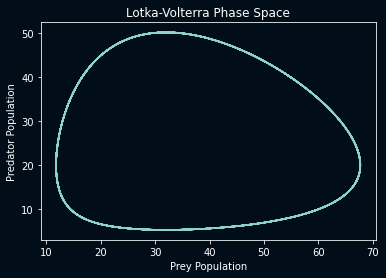

In [54]:
plt.plot(prey, predator)
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.title("Lotka-Volterra Phase Space")
plt.show()

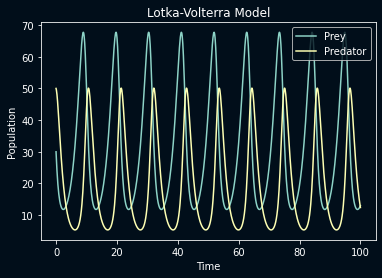

In [59]:
plt.plot(t, sol[:,0], label="Prey")
plt.plot(t, sol[:,1], label="Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Lotka-Volterra Model")
plt.legend()
plt.show()

## An Outline of the Neural Network Approach


The "New" approach involves an expensive *offline* step that then permits ultra-fast *online* ODE evaluations. By *offline*, I mean that we can offload the computational expense associated with approximating the ODE solution independently of any data associated with our system that we will observe. This offline step will likely be more costly than if we were to just approximate the ODE solution with some traditional solver, but the point is that the cost of this offline method will allow us to query solutions of the ODE ridiculously fast when we move *online* to perform inference with an MCMC algorithm.

This approach will also allow us to circumvent the aforementioned burden of having to compute solutions and gradients for all intermediary time points leading up to the times of our observations.
